In [1]:
from fredapi import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os

In [3]:
import os

os.environ['OMP_NUM_THREADS'] = '1'

In [4]:
from darts import TimeSeries
from darts.utils import statistics

In [5]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")

In [6]:
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]

In [7]:
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series).rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

In [8]:
economic_uncertainty = pd.read_csv("../data/UK_Daily_Policy_Data.csv")

In [9]:
economic_uncertainty["date"] = pd.to_datetime(economic_uncertainty.drop("daily_policy_index", axis=1))
economic_uncertainty = economic_uncertainty.drop(["day", "month", "year"], axis=1).set_index("date").squeeze()

In [10]:
economic_uncertainty

date
2001-01-01     50.70
2001-01-02    110.77
2001-01-03    179.41
2001-01-04    183.22
2001-01-05     89.31
               ...  
2025-03-17    981.09
2025-03-18    334.43
2025-03-19    460.00
2025-03-20    459.87
2025-03-21    622.87
Name: daily_policy_index, Length: 8846, dtype: float64

In [11]:
data = fred_series_list.copy()
data.append(economic_uncertainty)

In [12]:
data_ts = [TimeSeries.from_series(series) for series in data]

# First experiment: Job Listings on Indeed UK

In [13]:
series = data_ts[5]

In [14]:
# Feature extraction
df = pd.DataFrame(data[5])

In [15]:
df['year'] = df.index.year
df['month'] = df.index.month
df.reset_index(inplace=True)
df['week'] = df['date'].dt.isocalendar().week
df['day'] = df['date'].dt.dayofweek
df['day_str'] = df['date'].dt.strftime('%a')
df['year_month'] = df['date'].dt.strftime('%Y_%m')
df.set_index('date', inplace=True)

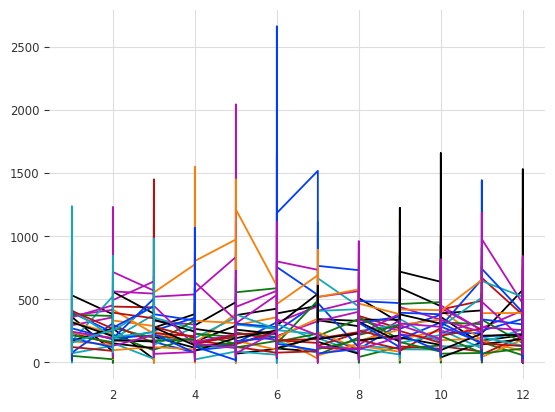

In [16]:
for year in df["year"].unique():
    plt.plot("month", df.columns[0], data=df[df["year"] == year])
plt.show()

In [17]:
df.describe()

,daily_policy_index,year,month,week,day
count,8846.000000,8846.000000,8846.000000,8846.0,8846.000000
mean,278.700058,2012.614063,6.480895,26.397242,2.999435
std,191.884355,6.992109,3.462180,15.117905,1.999972
min,0.000000,2001.000000,1.000000,1.0,0.000000
25%,150.105000,2007.000000,3.000000,13.0,1.000000
50%,234.950000,2013.000000,6.000000,26.0,3.000000
75%,360.657500,2019.000000,9.000000,39.75,5.000000
max,2660.720000,2025.000000,12.000000,53.0,6.000000


In [18]:
train, val = data_ts[5][:-90], data_ts[5][-90:]

In [19]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

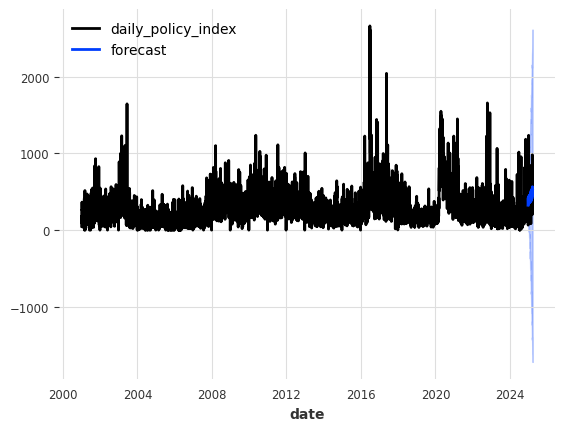

In [20]:
data_ts[5].plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

In [21]:
from darts.ad import KMeansScorer

scorer = KMeansScorer(k=2, window=5)
scorer.fit(train)
anom_score = scorer.score(val)

In [22]:
from darts.ad import QuantileDetector

detector = QuantileDetector(high_quantile=0.99)
detector.fit(scorer.score(train))
binary_anom = detector.detect(anom_score)

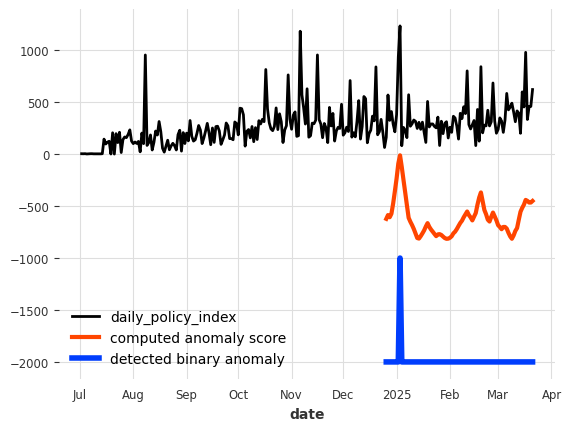

In [23]:
data_ts[5].drop_before(pd.Timestamp(2024, 7, 1)).plot()
(anom_score - 1000).plot(label="computed anomaly score", c="orangered", lw=3)
(binary_anom * 1000 - 2000).plot(label="detected binary anomaly", lw=4)
plt.show()

In [24]:
import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce GTX 1060 3GB


In [26]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper]}

In [29]:
# https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html
from darts.models import NBEATSModel
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0, pl_trainer_kwargs=pl_trainer_kwargs)
model.fit(train, val_series=val, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000021D43F515A0>]})

In [32]:
val_preds = model.predict(len(val))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

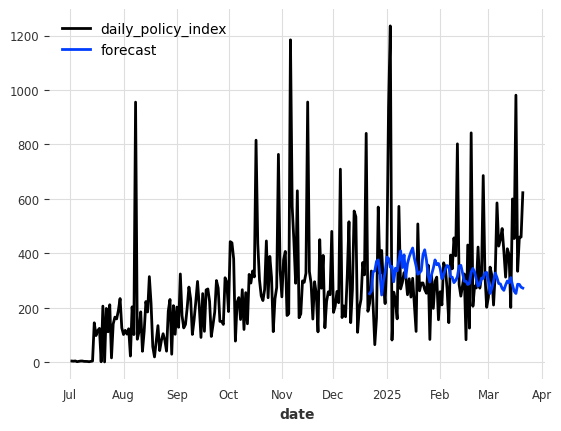

In [36]:
data_ts[5].drop_before(pd.Timestamp("2024-07-01")).plot()
val_preds.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()